In [1]:
from tensorflow.python.client import device_lib
devices=device_lib.list_local_devices()
def sizeof_fmt(num,suffix='B'):
    for unit in ['','Ki','Mi','Gi', 'Ti', 'Pi','Ei','Zi']:
        if abs(num)<1024.0:
            return "%3.1f %s%s" %(num, unit, suffix)
        num/=1024.0
    return "%.1f%s%s" %(num, 'Yi', suffix)
for d in devices:
    t=d.device_type
    name=d.physical_device_desc
    l = [item.split(':',1) for item in name.split(", ")]
    name_attr = dict([x for x in l if len (x)==2])
    dev = name_attr.get('name', 'Unnamed device')
    print(f" {d.name} || {dev} || {t} || {sizeof_fmt(d.memory_limit)}")

 /device:CPU:0 || Unnamed device || CPU || 256.0 MiB
 /device:GPU:0 ||  Quadro RTX 6000 || GPU || 21.7 GiB


In [2]:
from tqdm.notebook import tqdm_notebook
from scipy import ndimage
import tensorflow as tf
from skimage.transform import resize
from tensorflow.compat.v1.keras.backend import set_session
from flask import Flask, session
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)
set_session(sess)
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib
import pathlib
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras import backend as K
from tensorflow import losses, optimizers
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.metrics import top_k_categorical_accuracy
from scipy.ndimage import zoom
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

In [7]:
import nibabel as nib
def create_dataset(img_folder):
   
    img_data_array=[]
    class_name=[]
   
    for dir1 in tqdm_notebook(os.listdir(img_folder)):
        for file in tqdm_notebook(os.listdir(os.path.join(img_folder, dir1))):
       
            image_path= os.path.join(img_folder, dir1,  file)
            image = nib.load(image_path)
            img = image.get_fdata()
            img = zoom(img, (0.533, 0.533, 0.413)) 
            img [img<0] = 0
            img_nor = img / np.max(img)
            img_nor = img_nor.astype(np.float32)
            
            img_data_array.append(img_nor)
            class_name.append(dir1)
    return img_data_array, class_name

# extract the image array and class name

img_test, class_test =create_dataset(r'C:\\Dhruba Research Drive\\External for binary\\Class_enhCE')
img_test2, class_test2 =create_dataset(r'C:\\Dhruba Research Drive\\External for binary\\Class_enhT2')
img_test3, class_test3 =create_dataset(r'C:\\Dhruba Research Drive\\External for binary\\Class_edeT2')

####################################################################################################

target_dict_test={k: v for v, k in enumerate(np.unique(class_test))}
target_val_test=  [target_dict_test[class_test[i]] for i in range(len(class_test))]
print(target_dict_test)

#######################################################################################################

target_dict_test2={k: v for v, k in enumerate(np.unique(class_test2))}
target_val_test2=  [target_dict_test2[class_test2[i]] for i in range(len(class_test2))]
print(target_dict_test2)

#######################################################################################################

target_dict_test3={k: v for v, k in enumerate(np.unique(class_test3))}
target_val_test3=  [target_dict_test3[class_test3[i]] for i in range(len(class_test3))]
print(target_dict_test3)

#######################################################################################################
### Enh_CE tumor shape 
## For Test Set ###
x_test=np.array(img_test, np.float32)
y_test=np.array(list(map(int,target_val_test)), np.float32)
X_test = np.expand_dims(x_test, axis=4)

## Enh_T2 tumor shape 
## For Test Set ###
x_test2=np.array(img_test2, np.float32)
y_test2=np.array(list(map(int,target_val_test2)), np.float32)
X_test2 = np.expand_dims(x_test2, axis=4)

## Ede_T2 tumor shape 
## For Test Set ###
x_test3=np.array(img_test3, np.float32)
y_test3=np.array(list(map(int,target_val_test3)), np.float32)
X_test3 = np.expand_dims(x_test3, axis=4)

print("################ Enh_CE tumor shapes #####################")
print(X_test.shape)
print(y_test.shape)

print("############## Enh_T2 tumor Shapes ############################")
print(X_test2.shape)
print(y_test2.shape)

print("############## Ede_T2 tumor Shapes ############################")
print(X_test3.shape)
print(y_test3.shape)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

{'GBM': 0, 'Mets': 1}
{'GBM': 0, 'Mets': 1}
{'GBM': 0, 'Mets': 1}
################ Enh_CE tumor shapes #####################
(58, 128, 128, 64, 1)
(58,)
############## Enh_T2 tumor Shapes ############################
(58, 128, 128, 64, 1)
(58,)
############## Ede_T2 tumor Shapes ############################
(58, 128, 128, 64, 1)
(58,)


In [4]:
classification_model = load_model('CstmNt2_3inp_2class.epoch03-acc0.83.hdf5', compile = False)

Instructions for updating:
Colocations handled automatically by placer.


In [5]:
classification_model.summary()

Model: "CstmNet_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 6  0           []                               
                                4, 1)]                                                            
                                                                                                  
 input_2 (InputLayer)           [(None, 128, 128, 6  0           []                               
                                4, 1)]                                                            
                                                                                                  
 input_3 (InputLayer)           [(None, 128, 128, 6  0           []                               
                                4, 1)]                                                    

 conv1_1 (Conv3D)               (None, 7, 7, 3, 16)  13840       ['max_pooling3d_4[0][0]']        
                                                                                                  
 conv1_2 (Conv3D)               (None, 7, 7, 3, 16)  13840       ['max_pooling3d_7[0][0]']        
                                                                                                  
 batch_normalization_2 (BatchNo  (None, 7, 7, 3, 16)  64         ['conv1[0][0]']                  
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_5 (BatchNo  (None, 7, 7, 3, 16)  64         ['conv1_1[0][0]']                
 rmalization)                                                                                     
                                                                                                  
 batch_nor

In [8]:
y_pred = classification_model.predict(x=[X_test, X_test2, X_test3], batch_size = 20)
y_pred.shape

(58, 1)

In [11]:
# y_pred[y_pred>=0.5] = 1
# y_pred[y_pred<0.5] = 0

(128, 128, 64, 1)
(128, 128, 1)


Text(0.5, 1.0, 'T2-PTR')

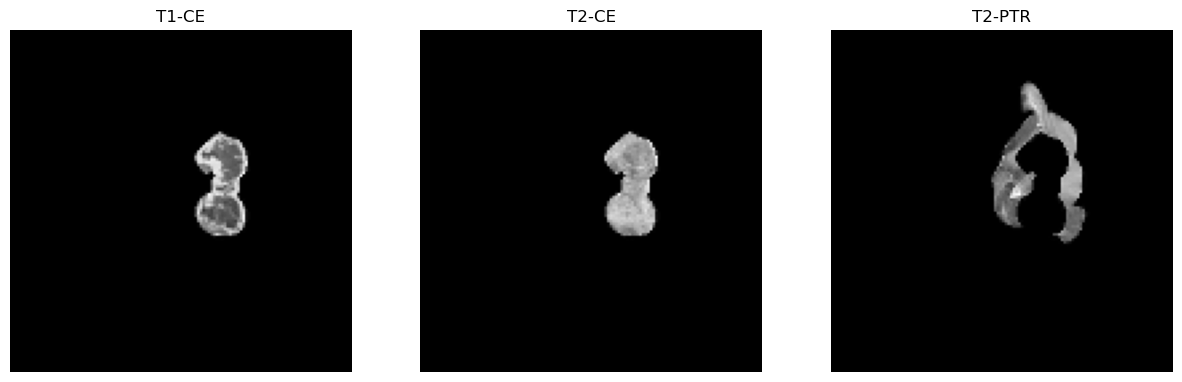

In [12]:
img = X_test[0]
img2 = X_test2[0]
img3 = X_test3[0]
print(img.shape)
sli = img[:, :, 35]
sli2 = img2[:, :, 35]
sli3 = img3[:, :, 35]
print(sli.shape)
vol = np.transpose(sli, (2, 1, 0))
vol = vol[0, :, :]
vol2 = np.transpose(sli2, (2, 1, 0))
vol2 = vol2[0, :, :]
vol3 = np.transpose(sli3, (2, 1, 0))
vol3 = vol3[0, :, :]
f, axarr = plt.subplots(1,3,figsize=(15,5));
img_plot = axarr[0].imshow(vol, cmap='gray');
axarr[0].axis('off')
axarr[0].set_title('T1-CE')

img_plot = axarr[1].imshow(vol2, cmap='gray');
axarr[1].axis('off')
axarr[1].set_title('T2-CE')

img_plot = axarr[2].imshow(vol3, cmap='gray');
axarr[2].axis('off')
axarr[2].set_title('T2-PTR')

In [16]:
def ScoreCam(model, img_array, img_array2, img_array3, layer_name, max_N=-1):

    cls = np.argmax(model.predict([img_array,img_array2, img_array3], steps = 1))
    act_map_array = Model(inputs=model.input, outputs=model.get_layer(layer_name).output).predict([img_array,img_array2, img_array3], steps = 1)
    
    # extract effective maps
    if max_N != -1:
        act_map_std_list = [np.std(act_map_array[0,:,:,:,k]) for k in range(act_map_array.shape[3])]
        unsorted_max_indices = np.argpartition(-np.array(act_map_std_list), max_N)[:max_N]
        max_N_indices = unsorted_max_indices[np.argsort(-np.array(act_map_std_list)[unsorted_max_indices])]
        act_map_array = act_map_array[:,:,:,:,max_N_indices]

    input_shape = model.layers[0].output_shape[0][1:]  # get input shape
    # 1. upsample to original input size
    act_map_resized_list = [cv2.resize(act_map_array[0,:,:,:,k], input_shape[:2], interpolation=cv2.INTER_LINEAR) for k in range(act_map_array.shape[4])]
    # 2. normalize the raw activation value in each activation map into [0, 1]
    act_map_normalized_list = []
    for act_map_resized in act_map_resized_list:
        if np.max(act_map_resized) - np.min(act_map_resized) != 0:
            act_map_normalized = act_map_resized / (np.max(act_map_resized) - np.min(act_map_resized))
        else:
            act_map_normalized = act_map_resized
        act_map_normalized_list.append(act_map_normalized)
    # 3. project highlighted area in the activation map to original input space by multiplying the normalized activation map
    masked_input_list = []
    masked_input_list2 = []
    masked_input_list3 = []
    for act_map_normalized in act_map_normalized_list:
        #masked_input = np.copy(img_array)
#         with session() as sess:
#             sess.run(tf.global_variables_initializer())
        masked_input = img_array.eval(session=sess)
        for k in range(1):
            masked_input[0,:,:,35,k] *= act_map_normalized[:,:,0]
        masked_input_list.append(masked_input)
        
    for act_map_normalized in act_map_normalized_list:
        masked_input2 = img_array2.eval(session=sess)
        for k in range(1):
            masked_input2[0,:,:,35,k] *= act_map_normalized[:,:,0]
        masked_input_list2.append(masked_input2)
        
    for act_map_normalized in act_map_normalized_list:
        masked_input3 = img_array3.eval(session=sess)
        for k in range(1):
            masked_input3[0,:,:,35,k] *= act_map_normalized[:,:,0]
        masked_input_list3.append(masked_input3)
        
    masked_input_array = np.concatenate(masked_input_list, axis=0)
    masked_input_array2 = np.concatenate(masked_input_list2, axis=0)
    masked_input_array3 = np.concatenate(masked_input_list3, axis=0)
    # 4. feed masked inputs into CNN model and softmax
    pred_from_masked_input_array = softmax(model.predict([masked_input_array, masked_input_array2, masked_input_array3], steps = 1))
    # 5. define weight as the score of target class
    weights = pred_from_masked_input_array[:,cls]
    print(weights.shape)
    # 6. get final class discriminative localization map as linear weighted combination of all activation maps
    cam = np.dot(act_map_array[0,:,:,:], weights)
    cam = resize(cam,(128,128,64))
    cam = np.maximum(0, cam)  # Passing through ReLU
    cam /= np.max(cam)  # scale 0 to 1.0
    return cam

def softmax(x):
    f = np.exp(x)/np.sum(np.exp(x), axis = 1, keepdims = True)
    return f

(32,)
(128, 128, 64)


Text(0.5, 1.0, 'Overlay')

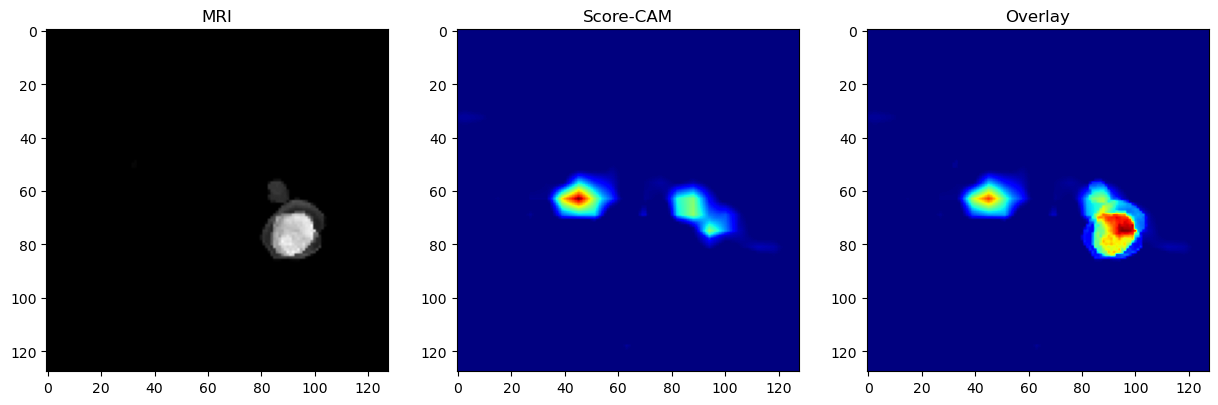

In [92]:
LAYER_NAME = 'conv2'
img_num = 57 #total 58 images, 0-57
image= X_test[img_num]
image2= X_test2[img_num]
image3= X_test3[img_num]
resized_img=image[:,:,:,0]
resized_img2=image2[:,:,:,0]
resized_img3=image3[:,:,:,0]
io_img=tf.expand_dims(image, axis=0)
io_img2=tf.expand_dims(image2, axis=0)
io_img3=tf.expand_dims(image3, axis=0)

heatmap = ScoreCam(classification_model, io_img, io_img2, io_img3, LAYER_NAME, max_N=-1)
print(heatmap.shape)
f, axarr = plt.subplots(1,3,figsize=(15,5));

## To move heatmap (-left)---(+right), (-up)---(+down)
M2 = np.float32([[1, 0, 0], [0, 1, 30]])

## warpAffine does appropriate shifting given the translation matrix.
#axial_grad_cmap_img2 = cv2.warpAffine(axial_grad_cmap_img, M1, (64, 128))

coronal_ct_img=np.squeeze(resized_img[:, :, 20]) #to view slice number 18; total slices 64, 0-63
coronal_ct_img2=np.squeeze(resized_img[:, :, 30]) #slice number 26 overlapping slice 18
coronal_ct_img3=np.squeeze(resized_img[:, :, 30])  
coronal_ct_img4=np.squeeze(resized_img[:, :, 48])  
coronal_ct_img5=np.squeeze(resized_img[:, :, 35])  #slice number 35 overlapping slice 18, 26, 54, 48

coronal_grad_cmap_img = np.squeeze(heatmap[:, :, 25]) #to view heatmap for slice number 25
coronal_grad_cmap_img2 = np.squeeze(heatmap[:, :, 30]) 
coronal_grad_cmap_img3 = np.squeeze(heatmap[:, :, 35]) 
coronal_grad_cmap_overlay = cv2.addWeighted(coronal_grad_cmap_img, 0.5, coronal_grad_cmap_img3, 0.5, 0)
coronal_grad_cmap_overlay = cv2.addWeighted(coronal_grad_cmap_img2, 0.5, coronal_grad_cmap_overlay, 0.5, 0)

##############################################################################################################
## uncomment below to apply the heatmap movement as specified by "M2"
coronal_grad_cmap_img = cv2.warpAffine(coronal_grad_cmap_overlay, M2, (128, 128))


img_overlay=cv2.addWeighted(coronal_ct_img, 0.5, coronal_ct_img2, 0.5, 0)
img_overlay=cv2.addWeighted(coronal_ct_img5, 0.5, img_overlay, 0.5, 0)

img_plot = axarr[0].imshow(img_overlay, cmap='gray');
axarr[0].axis('on')
axarr[0].set_title('MRI')

img_plot = axarr[1].imshow(coronal_grad_cmap_img, cmap='jet');
axarr[1].axis('on')
axarr[1].set_title('Score-CAM')
    
Coronal_overlay3=cv2.addWeighted(coronal_grad_cmap_img, 0.5, img_overlay, 0.5, 0)

    
img_plot = axarr[2].imshow(Coronal_overlay3,cmap='jet');
axarr[2].axis('on')
axarr[2].set_title('Overlay')